# leaf_segmentation_app

The goal of this app is to approximate the damaged area of a leaf.

**Input**:
- images

**Output**:
- leaf area (cm)
- damaged area (cm)
- percentage of damaged area (%)

### Data collection:
Images of the leafs are always taken:
- on a white sheet (easy segmentation)
- always from the same distance (consistent conversion from pixel to cm)
- different light conditions (could skew the image processing)

### Image processing:
- identify black points
- cut the image according to the points
- segment the leaf
- compute the leaf area in pixels
- process the image to clearly identify the damaged regions of the leaf
- compute the amount of pixels for the damaged area
- convert the areas to cm, according to the argument "conversion_rate"
- compute percentage damaged area -> if the leaf has a smaller area, this can still be used for estimating the loss in health of the leaf.

### Resources
- [contours with OpenCV](https://docs.opencv.org/4.x/d3/d05/tutorial_py_table_of_contents_contours.html)


### 1. Setup
- import patcher (for generating .py)
- import libraries
- import images
- plot sample image

In [9]:
# Import libraries

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

In [10]:
# Import images

wd = os.getcwd()

# Gets the file names in the image folder
def get_image_files(folder_path, valid_extensions=("jpg", "jpeg", "png")):
    return [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.lower().endswith(valid_extensions)]

# Set folder name
folder_path = "images" # todo: set parameter in streamlit

# Read image file names and import images
image_files = get_image_files(folder_path) # todo: running widget in streamlit
images = [cv2.imread(image_path) for image_path in image_files]

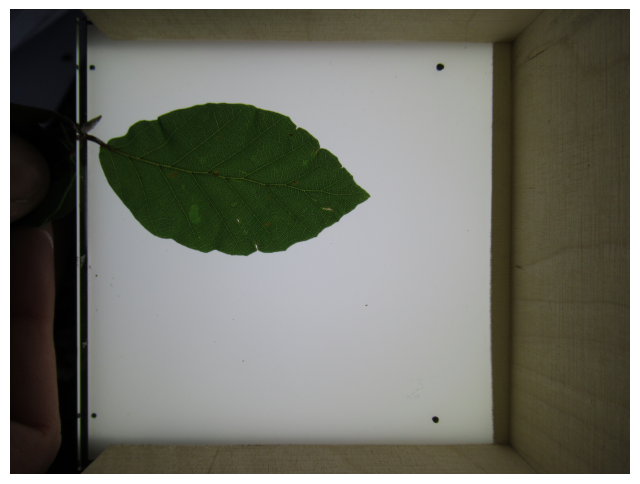

In [11]:
# Plot a sample image

sample_index = 0
sample_image = images[sample_index]

# Convert the sample image from BGR to RGB format
sample_image_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

# Plot the sample image
plt.figure(figsize=(8, 8))
plt.imshow(sample_image_rgb)
plt.axis('off')
plt.show()

### 2. Convert to gray according to threshold
- set threshold
- convert to gray
- apply threshold (used later for identifying contours)
- plot sample image

In [13]:
# Set threshold

gray_threshold = 70 # todo: set parameter in streamlit

In [14]:
# Convert image to gray

gray_img = cv2.cvtColor(sample_image, cv2.COLOR_BGR2GRAY)

In [15]:
# |export

# Apply threshold
_, thresholded_img = cv2.threshold(gray_img, gray_threshold, 255, cv2.THRESH_BINARY_INV)

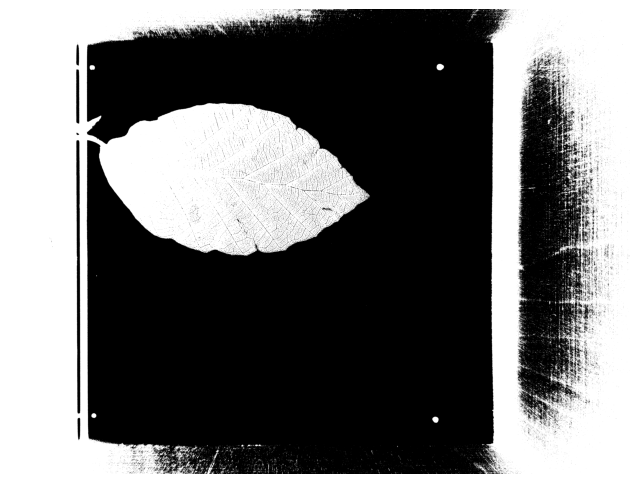

In [16]:
# Plot sample thresholded image

plt.figure(figsize=(8, 8))
plt.imshow(thresholded_img, cmap='gray')
plt.axis('off')
plt.show()

### 3. Identify contours
- compute contours (according to previously set threshold)

In [29]:
# Find contours on thresholded images

all_contours = []
contour_images = []

for image in images:
    # Convert image to gray
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply threshold
    _, thresholded_img = cv2.threshold(gray_img, gray_threshold, 255, cv2.THRESH_BINARY_INV)

    # Find contours on thresholded image
    contours, _ = cv2.findContours(thresholded_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Add the contours to the list
    all_contours.append(contours)

# Check the number of contours found for each image
for i, contours in enumerate(all_contours):
    print(f"Image {i}: {len(contours)} contours")

Image 0: 7046 contours
Image 1: 6668 contours
Image 2: 11355 contours
Image 3: 10061 contours
Image 4: 10953 contours
Image 5: 8258 contours
Image 6: 10412 contours
Image 7: 11811 contours
Image 8: 7385 contours
Image 9: 11143 contours
Image 10: 11798 contours
Image 11: 8577 contours
Image 12: 13061 contours
Image 13: 8616 contours
Image 14: 10461 contours
Image 15: 10503 contours
Image 16: 10094 contours
Image 17: 4074 contours


### 4. Draw contours on images
- Set min and max area threshold for the points.
- Filter the contours list according to the min/max thresholds.
- Plot a sample image to take a closer look.

In [31]:
# |export

# Define minimum and maximum area thresholds

min_area = 1000
max_area = 3000

In [32]:
# |export

filtered_contour_images = []

for img, contours in zip(images, all_contours):
    # Filter the contours according to the min/max thresholds
    filtered_contours = [cnt for cnt in contours if min_area <= cv2.contourArea(cnt) <= max_area]

    # Draw the rectangular contours on the original image
    filtered_contour_image = img.copy()
    cv2.drawContours(filtered_contour_image, filtered_contours, -1, (0, 255, 0), 2)

    # Convert the filtered contour image to RGB format for displaying using matplotlib
    filtered_contour_image_rgb = cv2.cvtColor(filtered_contour_image, cv2.COLOR_BGR2RGB)

    # Append the filtered contour image to the list
    filtered_contour_images.append(filtered_contour_image_rgb)

# |export

# Filter the contours according to the min/max thresholds

filtered_contour_images = []

for img, contours in zip(images, all_contours):
    # Filter the contours according to the min/max thresholds
    filtered_contours = [cnt for cnt in contours if min_area <= cv2.contourArea(cnt) <= max_area]

    # Draw the filtered contours on the original image
    filtered_contour_image = img.copy()
    cv2.drawContours(filtered_contour_image, filtered_contours, -1, (0, 255, 0), 2)

    # Convert the filtered contour image to RGB format for displaying using matplotlib
    filtered_contour_image_rgb = cv2.cvtColor(filtered_contour_image, cv2.COLOR_BGR2RGB)

    # Append the filtered contour image to the list
    filtered_contour_images.append(filtered_contour_image_rgb)

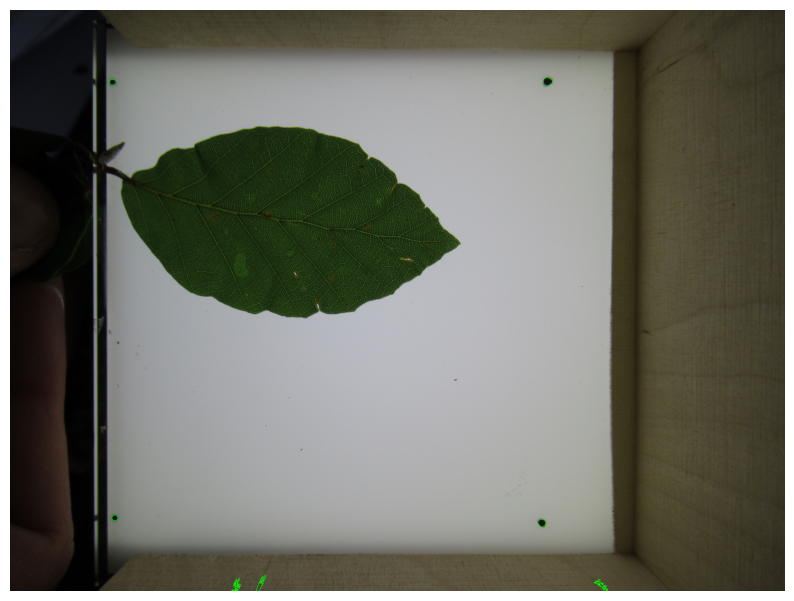

In [33]:
# |export

# Display a sample filtered contoured image

sample_index = 0
sample_filtered_contoured_image = filtered_contour_images[sample_index]

plt.figure(figsize=(10, 10))
plt.imshow(sample_filtered_contoured_image)
plt.axis('off')
plt.show()

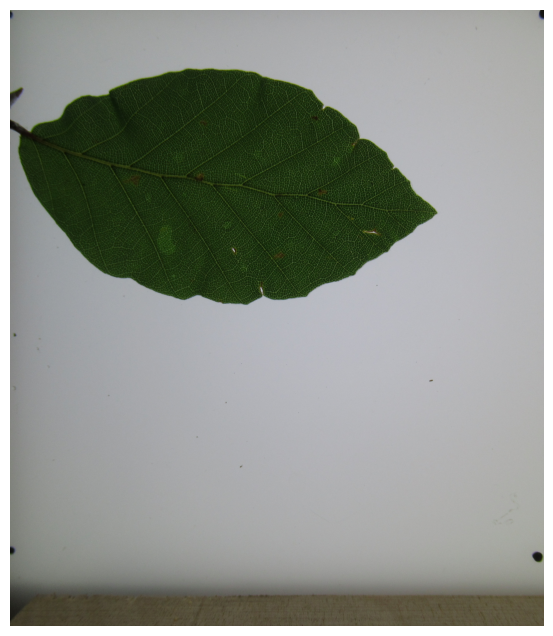

In [27]:
# |export

# todo: select only four of the contours! Use the expected length of the bounding box as parameter.
# todo: question, do the pixels change when the image size is different? A different cropping of the image would then not influence the leaf area.

# Get the bounding box of the contours
def get_final_bounding_box(filtered_contours):
    x_coords = []
    y_coords = []

    for cnt in filtered_contours:
        x, y, _, _ = cv2.boundingRect(cnt)
        x_coords.append(x)
        y_coords.append(y)

    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)

    return x_min, y_min, x_max, y_max

# Function to crop the image according to the bounding box
def crop_image(image, bbox):
    x_min, y_min, x_max, y_max = bbox
    return image[y_min:y_max, x_min:x_max]

# Get the bounding box of the filtered contours
bbox = get_final_bounding_box(filtered_contours)

# Crop the image according to the bounding box
cropped_image = crop_image(sample_image, bbox)

# Display the cropped image
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [563]:
# |export

from nbdev.export import nb_export

nb_export("leaf_segmentation_app.ipynb", lib_path="./", name="leaf_segmentation_app")